<a id='0'></a>
# 1. Problem Definition

In this Reinforcement Learning framework for trading strategy, the algorithm takes an action (buy, sell or hold) depending upon the current state of the stock price. The algorithm is trained using Deep Q-Learning framework, to help us predict
the best action, based on the current stock prices. 

The key components of the RL based framework are :
* Agent: Trading agent.
* Action: Buy, sell or hold.
* Reward function: Realized profit and loss (PnL) is used as the reward function
for this case study. The reward depends upon the action:
    * Sell: Realized profit and loss (sell price - bought price)
    * Buy: No reward
    * Hold: No Reward 

* State: Differences of past stock prices for a given time window is used as the state.

The data used for this case study will be the standard and poor's 500. The link to the data is : https://ca.finance.yahoo.com/quote/%255EGSPC/history?p=%255EGSPC).

<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import datetime
import math
from numpy.random import choice

import random
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import datetime as dt

#Import Model Packages for reinforcement learning
import tensorflow as tf
from keras import layers, models, optimizers, activations, Input
from keras import backend as K
from collections import namedtuple, deque

<a id='1.2'></a>
## 2.2. Loading the Data

In [2]:
#The data already obtained from yahoo finance is imported.
#dataset = read_csv('data/SP500.csv',index_col=0) 

In [3]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
#type(dataset)

In [57]:
start = dt.datetime(2017, 1, 1)
end = dt.datetime(2018, 1, 1)
count = 0
dataset = yf.download('VOO',start=start,end=end,
                      interval='1d')

#ADJ CLOSE DATA
price_data  = dataset["Adj Close"]
daily_pricedelta = price_data.pct_change()


[*********************100%***********************]  1 of 1 completed


<a id='2'></a>
# 3. Exploratory Data Analysis

In [58]:
# shape
dataset.shape

(251, 6)

In [59]:
# peek at data
set_option('display.width', 100)
dataset.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,206.68,207.33,205.56,206.74,190.140,4750200
2017-01-04,207.20,208.18,207.12,207.96,191.263,4622400
2017-01-05,207.75,208.04,207.01,207.80,191.115,2772100
2017-01-06,207.99,209.09,207.40,208.61,191.860,2194600
2017-01-09,208.34,208.48,207.89,207.95,191.253,1705200


The data has total 2344 rows and six columns which contain the open, high, low,
close and adjusted close price along with the total volume. The adjusted close is the
closing price adjusted for the split and dividends. For the purpose of this case study,
we will be focusing on the closing price.

In [60]:
# describe data
set_option('precision', 3)
dataset.describe()

,Open,High,Low,Close,Adj Close,Volume
count,251.000,251.000,251.000,251.000,251.000,2.510e+02
mean,224.736,225.280,224.126,224.791,208.356,1.964e+06
std,10.205,10.155,10.215,10.158,10.467,8.116e+05
min,206.680,207.330,205.560,206.740,190.140,7.683e+05
25%,217.645,217.940,216.635,217.375,200.100,1.420e+06
50%,223.820,224.320,223.240,223.870,207.112,1.766e+06
75%,230.895,231.315,230.675,231.250,215.734,2.326e+06
max,247.920,248.010,247.450,247.650,231.039,5.678e+06


Let us look at the plot of the stock movement. 

Text(0.5, 1.0, 'Price of VOO from \n 01-01-2019 - 01-01-2020')

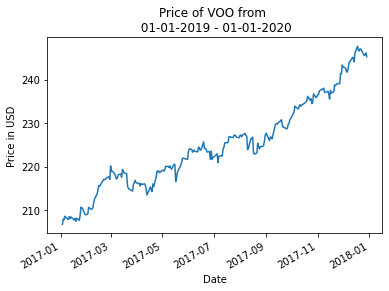

In [61]:
dataset['Close'].plot()
plt.ylabel('Price in USD')
plt.title('Price of VOO from \n 01-01-2019 - 01-01-2020') #VOO is just an index fund... Change as we may

<a id='3'></a>
## 4. Data Preparation

<a id='3.1'></a>
## 4.1. Data Cleaning
Let us check for the NAs in the rows, either drop them or fill them with the mean of the column

In [62]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = False


In case there are null values fill the missing values with the last value available in the dataset. 

In [63]:
# Fill the missing values with the last value available in the dataset. 
dataset=dataset.fillna(method='ffill')
dataset.head(2)
dataset_list = dataset['Adj Close']
dataset_list

Date
2017-01-03    190.140
2017-01-04    191.263
2017-01-05    191.115
2017-01-06    191.860
2017-01-09    191.253
               ...   
2017-12-22    230.442
2017-12-26    230.174
2017-12-27    230.305
2017-12-28    230.736
2017-12-29    229.939
Name: Adj Close, Length: 251, dtype: float64

The parameters to clusters are the indices and the variables used in the clustering are the columns. Hence the data is in the right format to be fed to the clustering algorithms

<a id='4'></a>
# 5. Evaluate Algorithms and Models

<a id='5.1'></a>
## 5.1. Train Test Split

We will use 80% of the dataset for modeling
and use 20% for testing.

In [64]:
# Adjusted for multi state dim prediction
dataset_df = pd.DataFrame(dataset)
X = dataset_df[["Adj Close", "Volume"]].astype(float).reset_index()
X = X.drop("Date", axis=1) # drop date col so it doesnt add a dim to the NN

validation_size = 0.2
#In case the data is not dependent on the time series, then train and test split should be done based on sequential sample
#This can be done by selecting an arbitrary split point in the ordered list of observations and creating two new datasets.
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
# min_max_scaler = MinMaxScaler((0,1))
std_scaler = StandardScaler()
X_train[['adj_close_scaled','volume_scaled']] = std_scaler.fit_transform(X_train)
X_test[['adj_close_scaled','volume_scaled']] = std_scaler.fit_transform(X_test)
X_train, X_test

(     Adj Close     Volume  adj_close_scaled  volume_scaled
 0      190.140  4.750e+06            -1.965          3.570
 1      191.263  4.622e+06            -1.809          3.408
 2      191.115  2.772e+06            -1.829          1.060
 3      191.860  2.195e+06            -1.726          0.327
 4      191.253  1.705e+06            -1.810         -0.294
 ..         ...        ...               ...            ...
 195    218.528  1.036e+06             1.973         -1.143
 196    218.193  1.079e+06             1.927         -1.088
 197    218.435  1.068e+06             1.960         -1.103
 198    218.780  1.767e+06             2.008         -0.215
 199    218.920  1.332e+06             2.028         -0.768
 
 [200 rows x 4 columns],
      Adj Close     Volume  adj_close_scaled  volume_scaled
 200    219.116  1.528e+06            -1.277         -0.615
 201    219.228  1.654e+06            -1.249         -0.473
 202    220.320  1.296e+06            -0.978         -0.878
 203    219.5

<a id='5.2'></a>
## 5.2. Implementation steps and modules

The algorithm, in simple terms decides whether to buy, sell or hold, when provided
with the current market price. The algorithm is based on “Q-learning based”
approach and used Deep-Q-Network (DQN) to come up with a policy. As discussed
before, the name “Q-learning” comes from the Q(s, a) function, that based on the
state s and provided action a returns the expected reward.


In order to implement this DQN algorithm several functions and modules are implemented that interact with each other during the model training. A summary of the
modules and functions is described below.

1. **Agent Class**: The agent is defined as “Agent” class, that holds the variables and
member functions that perform the Q-Learning that we discussed before. An
object of the “Agent” class is created using the training phase and is used for
training the model.
2. **Helper functions**: In this module, we create additional functions that are helpful
for training. There are two helper functions that we have are as follows.
3. **Training module**: In this step, we perform the training of the data using the vari‐
ables and the functions agent and helper methods. This will provide us with one
of three actions (i.e. buy, sell or hold) based on the states of the stock prices at the
end of the day. During training, the prescribed action for each day is predicted,
the rewards are computed and the deep-learning based Q-learning model
weights are updated iteratively over a number of episodes. Additionally, the profit
and loss of each action is summed up to see whether an overall profit has occur‐
red. The aim is to maximize the total profit.
We provide a deep dive into the interaction between different modules and functions
in the “Training the model” section below.
Let us look at the each of the modules in detail

<a id='5.3'></a>
## 5.3. Agent script

The definition of the Agent script is the key step, as it consists of the In this section, we will train an agent that will perform reinforcement learning based on the Q-Learning. We will perform the following steps to achieve this:

* Create an agent class whose initial function takes in the batch size, state size, and an evaluation Boolean function, to check whether the training is ongoing.
* In the agent class, create the following methods:
    * Constructor: The constructor inititalises all the parameters.
    * Model : This f unction has a deep learning model to map the state to action.
    * Act function :Returns an action, given a state, using the  output of the model function. The number of actions are defined as 3: sit, buy, sell
    * expReplay : Create a Replay function that adds, samples, and evaluates a buffer. Add a new experience to the replay buffer memory. Randomly sample a batch of experienced tuples from the memory. In the following function, we randomly sample states from a memory buffer. Experience replay stores a history of state, action, reward, and next state transitions that are experienced by the agent. It randomly samples mini-batches from this experience to update the network weights at each time step before the agent selects an ε-greedy action.

Experience replay increases sample efficiency, reduces the autocorrelation of samples that are collected during online learning, and limits the feedback due to the current weights producing training samples that can lead to local minima or divergence.

In [69]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from IPython.core.debugger import set_trace

import numpy as np
import random
from collections import deque

trainingValues = pd.DataFrame(columns = ['date', 'hold', 'buy', 'sell', 'choice', 'episode'])
testingValues = pd.DataFrame(columns = ['date', 'hold', 'buy', 'sell', 'choice'])
# pd.to_datetime(trainingValues["date"])


class Agent:
    def __init__(self, state_size, is_eval=False, model_name=""):
        #State size depends and is equal to the the window size, n previous days
        self.state_size = state_size # normalized previous days, 
        self.action_size = 3 # sit, buy, sell
        self.memory = deque(maxlen=1000)
        self.inventory = []
        self.model_name = model_name
        self.is_eval = is_eval

        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        #self.epsilon_decay = 0.9

        #self.model = self._model()

        self.model = load_model(model_name) if is_eval else self._model()

    #Deep Q Learning model- returns the q-value when given state as input
    def _model(self):
        model = Sequential()
        #Input Layer
        model.add(Dense(units=64, input_dim=self.state_size, activation="relu"))
        #Hidden Layers
        model.add(Dense(units=32, activation="relu"))
        model.add(Dense(units=8, activation="relu"))
        #Output Layer
        model.add(Dense(self.action_size, activation="linear"))
        model.compile(loss="mse", optimizer=Adam(lr=0.001)) 
        return model
  
    #Return the action on the value function
    #With probability (1-$\epsilon$) choose the action which has the highest Q-value.
    #With probability ($\epsilon$) choose any action at random.
    #Intitially high epsilon-more random, later less
    #The trained agents were evaluated by different initial random condition
    #and an e-greedy policy with epsilon 0.05. This procedure is adopted to minimize the possibility of overfitting during evaluation.
 
    def act(self, state): 
        
        global trainingValues, testingValues, start, count, dataset

        #If it is test and self.epsilon is still very high, once the epsilon become low, there are no random
        #actions suggested.
        if not self.is_eval and random.random() <= self.epsilon:
            rand_action = random.randrange(self.action_size)

            #Store all values to be outputted
            # start = dataset.index[count]
            trainingValues = trainingValues.append({'date': start, 'hold' : -1, 'buy' : -1, 'sell' : -1, 'choice' : rand_action}, ignore_index = True)             
            count += 1
            return rand_action
        options = self.model.predict(state)
        print("options")
        print(options)
        # start = dataset.index[count]
        #Store all values to be outputted
        trainingValues = trainingValues.append({'date': start,'hold' : options[0][0], 'buy' : options[0][1], 'sell' : options[0][2], 'choice' : np.argmax(options[0])}, ignore_index = True)
        testingValues = testingValues.append({'date': start,'hold' : options[0][0], 'buy' : options[0][1], 'sell' : options[0][2], 'choice' : np.argmax(options[0])}, ignore_index = True)

        # print(testingValues)
        
        count += 1
                                                                 #gather loss data here
        #set_trace()
        #action is based on the action that has the highest value from the q-value function.
        return np.argmax(options[0])

    def expReplay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size + 1, l):
            mini_batch.append(self.memory[i])
        
        # the memory during the training phase. 
        for state, action, reward, next_state, done in mini_batch:
            target = reward # reward or Q at time t    
            #update the Q table based on Q table equation
            #set_trace()
            if not done:
                #set_trace()
                #max of the array of the predicted. 
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])              #gather loss data here 
                
            # Q-value of the state currently from the table    
            target_f = self.model.predict(state)                                                       #gather loss data here
            
            # Update the output Q table for the given action in the table     
            target_f[0][action] = target
            #train and fit the model where state is X and target_f is Y, where the target is updated. 
            self.model.fit(state, target_f, epochs=1, verbose=0)                                       #gather epoch data here (training_loss)
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

<a id='5.4'></a>
## 5.4. Helper Functions

In this script, we will create functions that will be helpful for training. We create the following functions:

1) formatPrice:format the price to two decimal places, to reduce the ambiguity of the data:

2) getStockData: Return a vector of stock data from the CSV file. Convert the closing stock prices from the data to vectors, and return a vector of all stock prices.

3) getState: Define a function to generate states from the input vector. Create the time series by generating the states from the vectors created in the previous step. The function for this takes three parameters: the data; a time, t (the day that you want to predict); and a window (how many days to go back in time). The rate of change between these vectors will then be measured and based on the sigmoid function.

In [67]:
import numpy as np
import math

# prints formatted price
def formatPrice(n):
    return ("-$" if n < 0 else "$") + "{0:.2f}".format(abs(n))

# # returns the vector containing stock data from a fixed file 
# def getStockData(key):
#     vec = []
#     lines = open("data/" + key + ".csv", "r").read().splitlines()

#     for line in lines[1:]:
#         vec.append(float(line.split(",")[4])) #Only Close column

#     return vec

# returns the sigmoid
def sigmoid(x):
    return 1 / (1 + math.exp(-x))
def zach_sigmoid(x):
    return 1 / (1 + np.exp(-x))

# returns an an n-day state representation ending at time t
def getState(data, t, n):
    d = t - n + 1
    block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1] # pad with t0
    #block is which is the for [1283.27002, 1283.27002]
    print(block)
    res = []
    for i in range(n - 1):
        res.append(sigmoid(block[i + 1] - block[i]))

    return np.array([res])

# USED FOR TRAINING
# returns an an n-day state representation ending at time t
# feed it adj close, volume
# dataframe is used
def getNDimState(data, t, n):
  d = t - n + 1
  block = data.iloc[d:t+1] if d >= 0 else -d * data.iloc[0] + data.iloc[0:t+2] # pad with t0
  print(block)
  res = []
  for i in range(n - 1):
    res.append(zach_sigmoid(block.iloc[i+1] - block.iloc[i]))
  print("state")
  print(np.array(res))
  return np.array(res)

# USED FOR TESTING
# returns an an n-day state representation ending at time t
# feed it adj close, volume
# dataframe is used
def test_getNDimState(data, t, n):

  d = t - n + 1
  block = data.iloc[d:t+1] if d >= 0 else -d * data.iloc[0] + data.iloc[0:t+2] # pad with t0
  print(block)
  res = []
  for i in range(n - 1):
    res.append(zach_sigmoid(block.iloc[i]))
  print(np.array(res))
  return np.array(res)

# Plots the behavior of the output
def plot_behavior(data_input, states_buy, states_sell, profit):
    fig = plt.figure(figsize = (15,5))
    plt.plot(data_input, color='r', lw=2.)
    plt.plot(data_input, '^', markersize=10, color='m', label = 'Buying signal', markevery = states_buy)
    plt.plot(data_input, 'v', markersize=10, color='k', label = 'Selling signal', markevery = states_sell)
    plt.title('Total gains: %f'%(profit))
    plt.legend()
    #plt.savefig('output/'+name+'.png')
    plt.show()

## Get state testing

In [ ]:

def testing():
  df_list = pd.DataFrame(dataset_list)
  for i in range(20):
    print("HARIOM getState:")
    hariom = getState(dataset_list, i+1, 2)
    print(hariom)
    print("NDIM getState:")
    zach = getNDimState(df_list, i+1, 2)
    print(zach)
    print("TEST_NDIM getState:")
    test = getNDimState(df_list, i+1, 2)
    print(test)

    

In [ ]:
testing()

<a id='5.5'></a>
## 5.5. Training the data

We will proceed to train the data, based on our agent and helper methods. This will provide us with one of three actions, based on the states of the stock prices at the end of the day. These states can be to buy, sell, or hold. During training, the prescribed action for each day is predicted, and the price (profit, loss, or unchanged) of the action is calculated. The cumulative sum will be calculated at the end of the training period, and we will see whether there has been a profit or a loss. The aim is to maximize the total profit.

Steps: 
* Define the number of market days to consider as the window size and define the batch size with which the neural network will be trained.
* Instantiate the stock agent with the window size and batch size.
* Read the training data from the CSV file, using the helper function.
* The episode count is defined. The agent will look at the data for so many numbers of times. An episode represents a complete pass over the data.
* We can start to iterate through the episodes.
* Each episode has to be started with a state based on the data and window size. The inventory of stocks is initialized before going through the data.
* **Start to iterate over every day of the stock data. The action probability is predicted by the agent**. 
* Next, every day of trading is iterated, and the agent can act upon the data. Every day, the agent decides an action. Based on the action, the stock is held, sold, or bought.
* If the action is 1, then agent buys the stock. 
* If the action is 2, the agent sells the stocks and removes it from the inventory. Based on the sale, the profit (or loss) is calculated.

* If the action is 0, then there is no trade. The state can be called holding during that period.
* The details of the state, next state, action etc is saved in the memory of the agent object, which is used further by the exeReply function.       


Running episode 0/10
   adj_close_scaled  volume_scaled
0            -3.929          7.139
1            -3.774          6.977
state
[[0.53883328 0.45954659]]
   adj_close_scaled  volume_scaled
0            -1.965          3.570
1            -1.809          3.408
state
[[0.53883328 0.45954659]]
        date hold buy sell choice episode
0 2017-01-03   -1  -1   -1      2       0
   adj_close_scaled  volume_scaled
1            -1.809          3.408
2            -1.829          1.060
state
[[0.49489691 0.08723406]]
        date hold buy sell choice episode
0 2017-01-03   -1  -1   -1      2       0
1 2017-01-04   -1  -1   -1      0       0
   adj_close_scaled  volume_scaled
2            -1.829          1.060
3            -1.726          0.327
state
[[0.52581353 0.32458017]]
        date hold buy sell choice episode
0 2017-01-03   -1  -1   -1      2       0
1 2017-01-04   -1  -1   -1      0       0
2 2017-01-05   -1  -1   -1      0       0
   adj_close_scaled  volume_scaled
3            -1.72

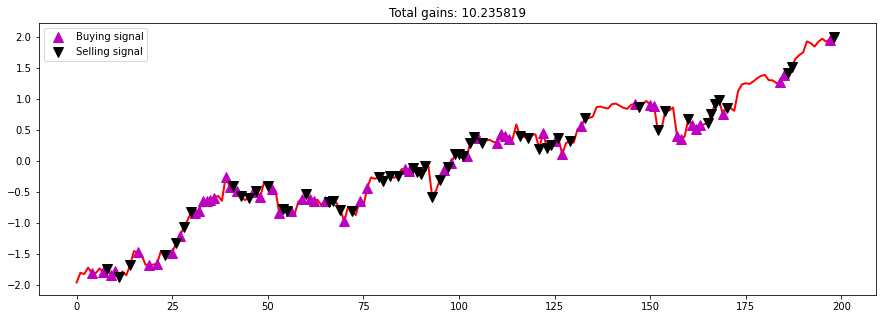

INFO:tensorflow:Assets written to: 2017/saved_models/2layer/model_ep0/assets
Running episode 1/10
   adj_close_scaled  volume_scaled
0            -3.929          7.139
1            -3.774          6.977
state
[[0.53883328 0.45954659]]
options
[[0.98822165 1.0476009  1.0743552 ]]
   adj_close_scaled  volume_scaled
0            -1.965          3.570
1            -1.809          3.408
state
[[0.53883328 0.45954659]]
          date   hold    buy   sell choice episode
0   2017-01-03     -1     -1     -1      2       0
1   2017-01-04     -1     -1     -1      0       0
2   2017-01-05     -1     -1     -1      0       0
3   2017-01-06     -1     -1     -1      2       0
4   2017-01-09     -1     -1     -1      1       0
..         ...    ...    ...    ...    ...     ...
195 2017-10-11     -1     -1     -1      0       0
196 2017-10-12     -1     -1     -1      2       0
197 2017-10-13     -1     -1     -1      1       0
198 2017-10-16   1.07  1.158   1.22      2       0
199 2017-01-03  0.988 

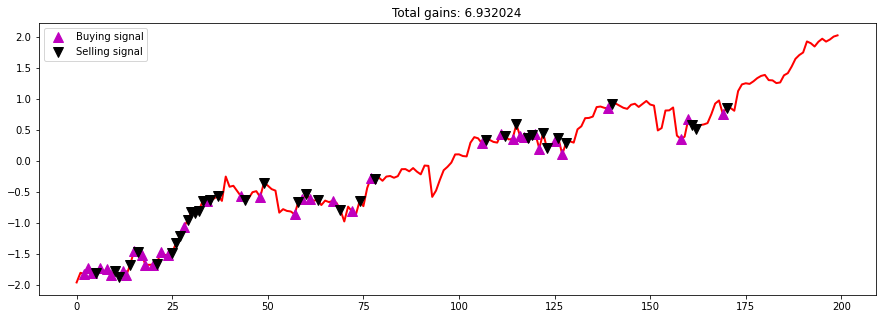

Running episode 2/10
   adj_close_scaled  volume_scaled
0            -3.929          7.139
1            -3.774          6.977
state
[[0.53883328 0.45954659]]
options
[[0.0880316  0.08464898 0.11104154]]
   adj_close_scaled  volume_scaled
0            -1.965          3.570
1            -1.809          3.408
state
[[0.53883328 0.45954659]]
          date   hold    buy   sell choice episode
0   2017-01-03     -1     -1     -1      2       0
1   2017-01-04     -1     -1     -1      0       0
2   2017-01-05     -1     -1     -1      0       0
3   2017-01-06     -1     -1     -1      2       0
4   2017-01-09     -1     -1     -1      1       0
..         ...    ...    ...    ...    ...     ...
394 2017-10-11  0.153   0.14  0.165      2       1
395 2017-10-12     -1     -1     -1      0       1
396 2017-10-13     -1     -1     -1      2       1
397 2017-10-16  0.099   0.09  0.117      2       1
398 2017-01-03  0.088  0.085  0.111      2       2

[399 rows x 6 columns]
options
[[0.06629261 0.0

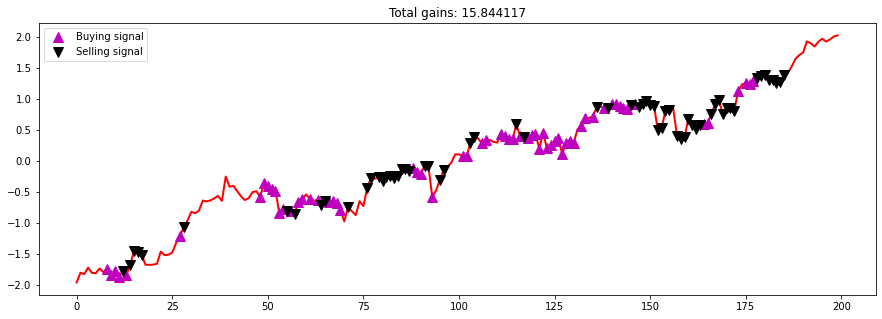

INFO:tensorflow:Assets written to: 2017/saved_models/2layer/model_ep2/assets
Running episode 3/10
   adj_close_scaled  volume_scaled
0            -3.929          7.139
1            -3.774          6.977
state
[[0.53883328 0.45954659]]
options
[[3.7709465 3.7208366 3.7380083]]
   adj_close_scaled  volume_scaled
0            -1.965          3.570
1            -1.809          3.408
state
[[0.53883328 0.45954659]]
          date   hold    buy   sell choice episode
0   2017-01-03     -1     -1     -1      2       0
1   2017-01-04     -1     -1     -1      0       0
2   2017-01-05     -1     -1     -1      0       0
3   2017-01-06     -1     -1     -1      2       0
4   2017-01-09     -1     -1     -1      1       0
..         ...    ...    ...    ...    ...     ...
593 2017-10-11  4.107  4.041  4.128      2       2
594 2017-10-12  3.942  3.876   3.95      2       2
595 2017-10-13  3.901  3.825  3.883      0       2
596 2017-10-16  3.707  3.707   3.82      2       2
597 2017-01-03  3.771  3.

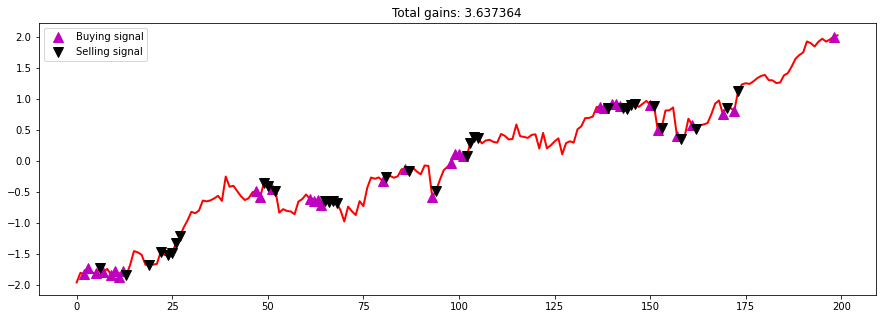

Running episode 4/10
   adj_close_scaled  volume_scaled
0            -3.929          7.139
1            -3.774          6.977
state
[[0.53883328 0.45954659]]
options
[[0.24710327 0.24626184 0.28261855]]
   adj_close_scaled  volume_scaled
0            -1.965          3.570
1            -1.809          3.408
state
[[0.53883328 0.45954659]]
          date   hold    buy   sell choice episode
0   2017-01-03     -1     -1     -1      2       0
1   2017-01-04     -1     -1     -1      0       0
2   2017-01-05     -1     -1     -1      0       0
3   2017-01-06     -1     -1     -1      2       0
4   2017-01-09     -1     -1     -1      1       0
..         ...    ...    ...    ...    ...     ...
792 2017-10-11  0.276  0.274  0.283      2       3
793 2017-10-12  0.276  0.276  0.273      0       3
794 2017-10-13  0.272  0.272  0.277      2       3
795 2017-10-16   0.27  0.278  0.276      1       3
796 2017-01-03  0.247  0.246  0.283      2       4

[797 rows x 6 columns]
options
[[0.1984705  0.1

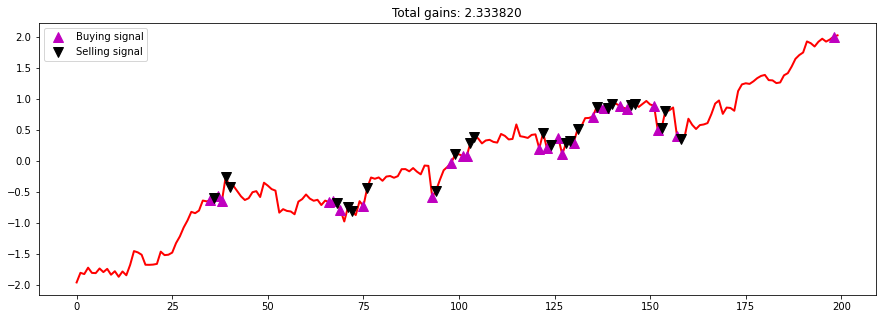

INFO:tensorflow:Assets written to: 2017/saved_models/2layer/model_ep4/assets
Running episode 5/10
   adj_close_scaled  volume_scaled
0            -3.929          7.139
1            -3.774          6.977
state
[[0.53883328 0.45954659]]
options
[[0.00220814 0.00344121 0.05499144]]
   adj_close_scaled  volume_scaled
0            -1.965          3.570
1            -1.809          3.408
state
[[0.53883328 0.45954659]]
          date   hold    buy   sell choice episode
0   2017-01-03     -1     -1     -1      2       0
1   2017-01-04     -1     -1     -1      0       0
2   2017-01-05     -1     -1     -1      0       0
3   2017-01-06     -1     -1     -1      2       0
4   2017-01-09     -1     -1     -1      1       0
..         ...    ...    ...    ...    ...     ...
991 2017-10-11  0.017  0.024  0.048      2       4
992 2017-10-12  0.016   0.03  0.038      2       4
993 2017-10-13  0.013  0.022  0.043      2       4
994 2017-10-16  0.044  0.059  0.046      1       4
995 2017-01-03  0.002 

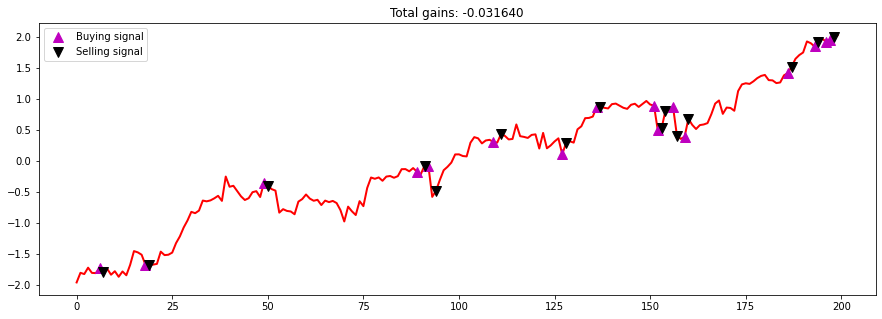

Running episode 6/10
   adj_close_scaled  volume_scaled
0            -3.929          7.139
1            -3.774          6.977
state
[[0.53883328 0.45954659]]
options
[[0.17355797 0.17927217 0.18512619]]
   adj_close_scaled  volume_scaled
0            -1.965          3.570
1            -1.809          3.408
state
[[0.53883328 0.45954659]]
           date   hold    buy   sell choice episode
0    2017-01-03     -1     -1     -1      2       0
1    2017-01-04     -1     -1     -1      0       0
2    2017-01-05     -1     -1     -1      0       0
3    2017-01-06     -1     -1     -1      2       0
4    2017-01-09     -1     -1     -1      1       0
...         ...    ...    ...    ...    ...     ...
1190 2017-10-11  0.189  0.201  0.202      2       5
1191 2017-10-12  0.188  0.198  0.186      1       5
1192 2017-10-13  0.179  0.189  0.187      1       5
1193 2017-10-16  0.157  0.182  0.192      2       5
1194 2017-01-03  0.174  0.179  0.185      2       6

[1195 rows x 6 columns]
options
[[0

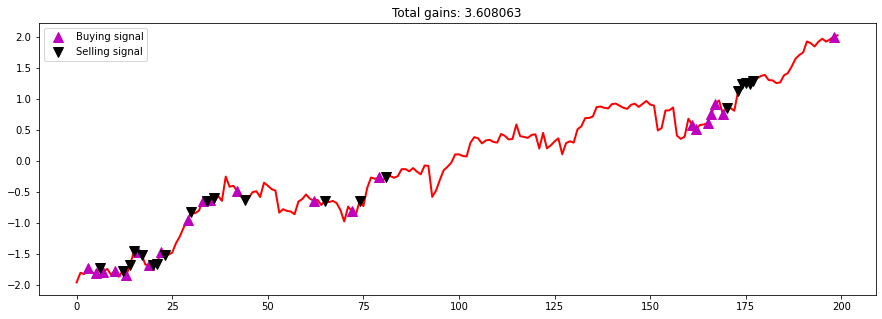

INFO:tensorflow:Assets written to: 2017/saved_models/2layer/model_ep6/assets
Running episode 7/10
   adj_close_scaled  volume_scaled
0            -3.929          7.139
1            -3.774          6.977
state
[[0.53883328 0.45954659]]
options
[[2.0394588 2.1184087 2.1281037]]
   adj_close_scaled  volume_scaled
0            -1.965          3.570
1            -1.809          3.408
state
[[0.53883328 0.45954659]]
           date   hold    buy   sell choice episode
0    2017-01-03     -1     -1     -1      2       0
1    2017-01-04     -1     -1     -1      0       0
2    2017-01-05     -1     -1     -1      0       0
3    2017-01-06     -1     -1     -1      2       0
4    2017-01-09     -1     -1     -1      1       0
...         ...    ...    ...    ...    ...     ...
1389 2017-10-11  2.304  2.363  2.418      2       6
1390 2017-10-12  2.188  2.247  2.275      2       6
1391 2017-10-13  2.132  2.194  2.219      2       6
1392 2017-10-16  2.075  2.136  2.135      1       6
1393 2017-01-0

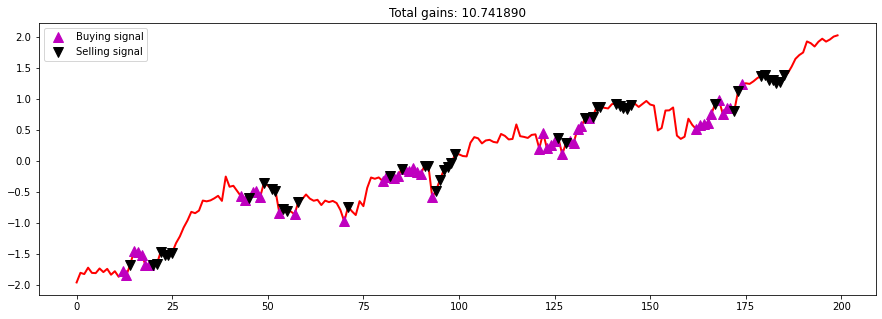

Running episode 8/10
   adj_close_scaled  volume_scaled
0            -3.929          7.139
1            -3.774          6.977
state
[[0.53883328 0.45954659]]
options
[[3.6579    3.667591  3.8322935]]
   adj_close_scaled  volume_scaled
0            -1.965          3.570
1            -1.809          3.408
state
[[0.53883328 0.45954659]]
           date   hold    buy   sell choice episode
0    2017-01-03     -1     -1     -1      2       0
1    2017-01-04     -1     -1     -1      0       0
2    2017-01-05     -1     -1     -1      0       0
3    2017-01-06     -1     -1     -1      2       0
4    2017-01-09     -1     -1     -1      1       0
...         ...    ...    ...    ...    ...     ...
1588 2017-10-11  4.344  4.397  4.656      2       7
1589 2017-10-12  4.206  4.228   4.43      2       7
1590 2017-10-13  3.985  4.018  4.226      2       7
1591 2017-10-16  3.843  3.846  4.044      2       7
1592 2017-01-03  3.658  3.668  3.832      2       8

[1593 rows x 6 columns]
options
[[2.88

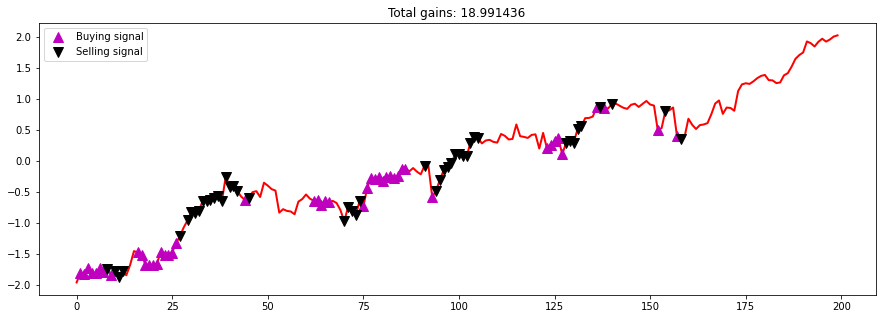

INFO:tensorflow:Assets written to: 2017/saved_models/2layer/model_ep8/assets
Running episode 9/10
   adj_close_scaled  volume_scaled
0            -3.929          7.139
1            -3.774          6.977
state
[[0.53883328 0.45954659]]
options
[[ 0.0268015  -0.00183815  0.04877863]]
   adj_close_scaled  volume_scaled
0            -1.965          3.570
1            -1.809          3.408
state
[[0.53883328 0.45954659]]
           date   hold    buy   sell choice episode
0    2017-01-03     -1     -1     -1      2       0
1    2017-01-04     -1     -1     -1      0       0
2    2017-01-05     -1     -1     -1      0       0
3    2017-01-06     -1     -1     -1      2       0
4    2017-01-09     -1     -1     -1      1       0
...         ...    ...    ...    ...    ...     ...
1787 2017-10-11  0.054  0.024  0.068      2       8
1788 2017-10-12  0.051  0.023  0.061      2       8
1789 2017-10-13  0.043  0.014  0.057      2       8
1790 2017-10-16   0.05  0.024  0.044      0       8
1791 201

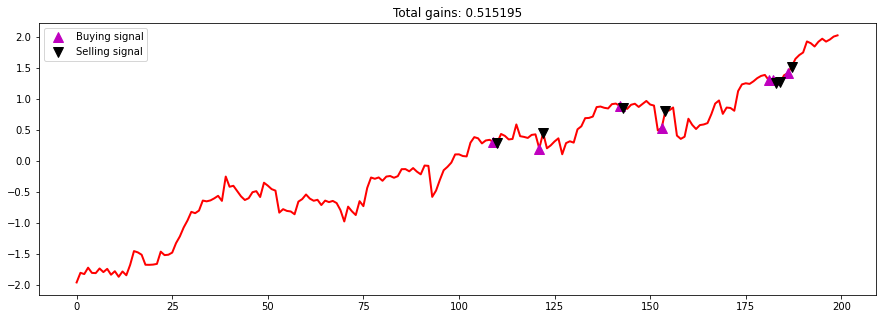

Running episode 10/10
   adj_close_scaled  volume_scaled
0            -3.929          7.139
1            -3.774          6.977
state
[[0.53883328 0.45954659]]
options
[[0.05741188 0.06700143 0.08316538]]
   adj_close_scaled  volume_scaled
0            -1.965          3.570
1            -1.809          3.408
state
[[0.53883328 0.45954659]]
           date   hold    buy   sell choice episode
0    2017-01-03     -1     -1     -1      2       0
1    2017-01-04     -1     -1     -1      0       0
2    2017-01-05     -1     -1     -1      0       0
3    2017-01-06     -1     -1     -1      2       0
4    2017-01-09     -1     -1     -1      1       0
...         ...    ...    ...    ...    ...     ...
1986 2017-10-11   0.06   0.07  0.082      2       9
1987 2017-10-12  0.061  0.068  0.076      2       9
1988 2017-10-13  0.059  0.065  0.077      2       9
1989 2017-10-16  0.063  0.071  0.084      2       9
1990 2017-01-03  0.057  0.067  0.083      2      10

[1991 rows x 6 columns]
options
[[

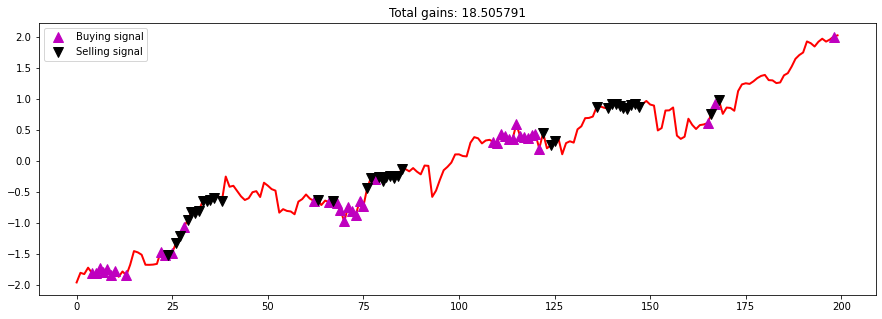

INFO:tensorflow:Assets written to: 2017/saved_models/2layer/model_ep10/assets


In [68]:
from IPython.core.debugger import set_trace
window_size = 1
num_state_vals = 2 # change for number of dimensions
agent = Agent(num_state_vals)
#In this step we feed the closing value of the stock price
data = X_train
l = len(data) - 1
batch_size = 32
#An episode represents a complete pass over the data.
episode_count = 10
global trainingValues, start, count
# sigmoid_distribution = pd.DataFrame(columns = ['train_close_sigmoid', 'train_volume_sigmoid'])


for e in range(episode_count + 1):
    print("Running episode " + str(e) + "/" + str(episode_count))
    state = getNDimState(data[['adj_close_scaled', 'volume_scaled']], 0, window_size + 1)
    # sigmoid_distribution = sigmoid_distribution.append({'train_close_sigmoid':state[0][0], 'train_volume_sigmoid':state[0][1]}, ignore_index=True)

    #set_trace()
    total_profit = 0                                                            
    agent.inventory = []
    states_sell = []
    states_buy = []
    start = dt.datetime(2018, 1, 1) # reset date for each episode
    count = 0
    for t in range(l):
        action = agent.act(state) 
        trainingValues.at[trainingValues.index[-1],'episode'] = e # add episode num to vis data
        # print("Action: ")   
        # print(action)
        # sit
        next_state = getNDimState(data[['adj_close_scaled', 'volume_scaled']], t + 1, window_size + 1)
        # sigmoid_distribution = sigmoid_distribution.append({'train_close_sigmoid':next_state[0][0], 'train_volume_sigmoid':next_state[0][1]}, ignore_index=True)

#         print(sigmoid_distribution)
        # print("NEXT STATE")
        # print(next_state)
        reward = 0

        if action == 1: # buy
            agent.inventory.append(data["adj_close_scaled"].iloc[t])
            states_buy.append(t)
            #print("Buy: " + formatPrice(data[t]))

        elif action == 2 and len(agent.inventory) > 0: # sell
            bought_price = agent.inventory.pop(0)
            reward = max(data["adj_close_scaled"].iloc[t] - bought_price, 0)
            total_profit += data["adj_close_scaled"].iloc[t] - bought_price
            states_sell.append(t)
            #print("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - bought_price))

            # trainingValues.at[trainingValues.index[-1],'daily profit'] = daily_profit
        
        print(trainingValues) # for testing

        done = True if t == l - 1 else False
        #appends the details of the state action etc in the memory, which is used further by the exeReply function
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state

        if done:
            print("--------------------------------")
            print("Total Profit: " + formatPrice(total_profit))
            print("--------------------------------")
            #set_trace()
            #pd.DataFrame(np.array(agent.memory)).to_csv("Agent"+str(e)+".csv")
            #Chart to show how the model performs with the stock goin up and down for each 
            # trainingValues.index = trainingValues['date']
            # trainingValues.drop(['date'], axis=1)
            trainingValues.to_csv("2017/2layer_training_data.csv", mode='w', index=False)
            # sigmoid_distribution.to_csv("sigmoid_distribution.csv", mode='w', index=False)
            plot_behavior(data["adj_close_scaled"], states_buy, states_sell, total_profit)
            
        if len(agent.memory) > batch_size:
            agent.expReplay(batch_size)
            

    if e % 2 == 0:
        agent.model.save("2017/saved_models/2layer/model_ep" + str(e))

In [ ]:
#Deep Q-Learning Model
print(agent.model.summary())



<a id='6'></a>
# 6. Testing the Data 

After training the data, it is tested it against the test dataset. Our model resulted in a overall profit. The best thing about the model was that the profits kept improving over time, indicating that it was learning well and taking better actions.

## Multi-Dimensional state testing

In [75]:
# FOR CUSTOM(NON-YFINANCE) DATA
import io
# empty_df = pd.read_csv(io.BytesIO(uploaded['empty_df.csv']))
empty_df = pd.read_csv("2017/saved_models/2layer_default/empty_df_2layer_default.csv")

data = X_train
window_size = 1
num_state_vals = 2 # change for number of dimensions
agent = Agent(num_state_vals)

#agent is already defined in the training set above.
test_data = empty_df.reset_index()
shuffled_test_data = empty_df.sample(frac=1).reset_index(drop=True)

print(shuffled_test_data)
l_test = len(empty_df)
state = test_getNDimState(shuffled_test_data[['empty_price_scaled', 'empty_volume_scaled']], 0, window_size + 1) # inserting state deltas to get actions for empty days(heatmap)

total_profit = 0

is_eval = True
done = False
states_sell_test = []
states_buy_test = []

#Get the trained model
model_path = "2017/saved_models/2layer_default/model_ep10"
agent = Agent(window_size, is_eval, model_path)
state = getNDimState(data[['adj_close_scaled', 'volume_scaled']], 0, window_size + 1)
total_profit = 0
agent.inventory = []
# sigmoid_distribution_test = pd.DataFrame(columns = ['test_close_sigmoid', 'test_volume_sigmoid'])

# for X_test data
# start = dt.datetime(2017, 1, 1)
# end = dt.datetime(2018, 1, 1)
# dataset = yf.download('VOO',start=start,end=end,
#                       interval='1d')
# testingValues = testingValues.iloc[0:0]



     Price Delta  Volume Delta  adj close  empty_price_scaled  empty_volume_scaled
0         -0.135       171.712     99.865              -0.742                1.398
1          0.466        46.340    100.466               0.706               -0.255
2          0.240        32.410    100.240               0.163               -0.438
3          0.766        -9.380    100.766               1.430               -0.989
4          0.165        -9.380    100.165              -0.018               -0.989
..           ...           ...        ...                 ...                  ...
326        0.691       -65.101    100.691               1.249               -1.723
327        0.766        88.131    100.766               1.430                0.296
328       -0.135       -23.310     99.865              -0.742               -1.173
329        0.841        -9.380    100.841               1.611               -0.989
330        0.315       102.061    100.315               0.344                0.480

[33

options
[[0.25093207 0.27303076 0.26491925]]
   empty_price_scaled  empty_volume_scaled
0              -1.648                1.581
1              -0.380               -1.723
[[0.16144501 0.82941243]]
Buy: -$1.65
options
[[0.3243569  0.36984837 0.33350083]]
   empty_price_scaled  empty_volume_scaled
1              -0.380               -1.723
2               1.611               -0.989
[[0.4060898  0.15142428]]
Buy: -$0.38
options
[[0.32520515 0.3591609  0.32874078]]
   empty_price_scaled  empty_volume_scaled
2               1.611               -0.989
3              -0.742                0.847
[[0.8336077  0.27110134]]
Buy: $1.61
options
[[0.17691135 0.17475261 0.20176232]]
   empty_price_scaled  empty_volume_scaled
3              -0.742                0.847
4              -1.285                0.847
[[0.32251076 0.69994524]]
Sell: -$0.74 | profit: $0.91
options
[[0.30103362 0.33681554 0.31213856]]
   empty_price_scaled  empty_volume_scaled
4              -1.285                0.847
5    

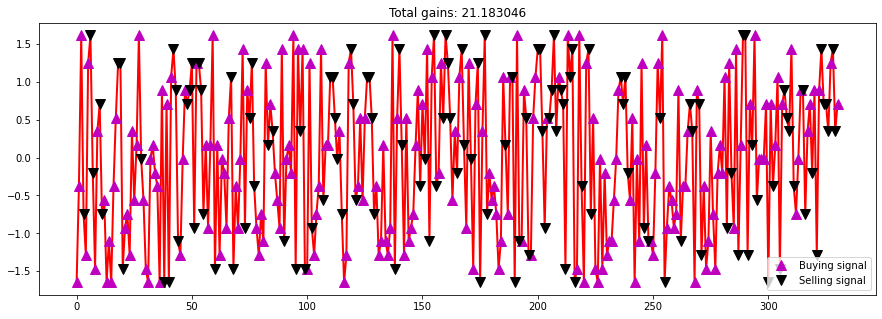

In [56]:
for t in range(l_test):
    action = agent.act(state)
    #print(action)
    #set_trace()
    empty_df.loc[t, 'Choice'] = action
    next_state = test_getNDimState(shuffled_test_data[['empty_price_scaled', 'empty_volume_scaled']], t + 1, window_size + 1)
    # sigmoid_distribution_test = sigmoid_distribution_test.append({'train_close_sigmoid':next_state[0][0], 'train_volume_sigmoid':next_state[0][1]}, ignore_index=True)

    reward = 0

    if action == 1:
        agent.inventory.append(shuffled_test_data["empty_price_scaled"].iloc[t])
        states_buy_test.append(t)
        print("Buy: " + formatPrice(shuffled_test_data["empty_price_scaled"].iloc[t]))

    elif action == 2 and len(agent.inventory) > 0:
        bought_price = agent.inventory.pop(0)
        reward = max(shuffled_test_data["empty_price_scaled"].iloc[t] - bought_price, 0)
        #reward = test_data[t] - bought_price
        total_profit += shuffled_test_data["empty_price_scaled"].iloc[t] - bought_price
        states_sell_test.append(t)
        print("Sell: " + formatPrice(shuffled_test_data["empty_price_scaled"].iloc[t]) + " | profit: " + formatPrice(shuffled_test_data["empty_price_scaled"].iloc[t] - bought_price))

    if t == l_test - 1:
        done = True
        
    # print("State: ", state, "Action:", action, "Reward: ", reward, "Next state: ", next_state)
    agent.memory.append((state, action, reward, next_state, done))
    state = next_state
    # start = X_test.index[t]
    

    if done:
        print("------------------------------------------")
        print("Total Profit: " + formatPrice(total_profit))
        print("------------------------------------------")

# testingValues.to_csv("testing_data.csv", index=False)
empty_df.to_csv("heatmap_data_2layer_default.csv", index=False)
# sigmoid_distribution_test.to_csv("sig_test.csv", index=False)
plot_behavior(shuffled_test_data["empty_price_scaled"],states_buy_test, states_sell_test, total_profit)

## Init for when Testing and Training are same

In [72]:
# save testing data for dashboard
# global start
# # global dataset, count, end, X
# start = dt.datetime(2017, 10, 16)
# end = dt.datetime(2019, 1, 1)
# dataset = yf.download('VOO',start=start,end=end,
#                       interval='1d')
# # Adjusted for multi state dim prediction
# dataset_df = pd.DataFrame(dataset)
# X = dataset_df[["Adj Close", "Volume"]].astype(float).reset_index()
# X = X.drop("Date", axis=1) # drop date col so it doesnt add a dim to the NN

# validation_size = 0.2
# #In case the data is not dependent on the time series, then train and test split should be done based on sequential sample
# #This can be done by selecting an arbitrary split point in the ordered list of observations and creating two new datasets.
# train_size = int(len(X) * (1-validation_size))
# X_train, X_test = X[0:train_size], X[train_size:len(X)]
# min_max_scaler = MinMaxScaler((0,1))
# X_train[['adj_close_scaled','volume_scaled']] = min_max_scaler.fit_transform(X_train)
# X_test[['adj_close_scaled','volume_scaled']] = min_max_scaler.fit_transform(X_test)

count = 200 # start row for testing part of dataset

#agent is already defined in the training set above.
test_data = X_test.reset_index()
l_test = len(test_data) - 1
state = getNDimState(test_data[['adj_close_scaled', 'volume_scaled']], 0, window_size + 1)
total_profit = 0
is_eval = True
done = False
states_sell_test = []
states_buy_test = []
#Get the trained model
model_path = "2017/saved_models/2layer_default/model_ep10"
agent = Agent(window_size, is_eval, model_path)
state = getNDimState(data[['adj_close_scaled', 'volume_scaled']], 0, window_size + 1)
total_profit = 0
agent.inventory = []

# global testingValues # needed for writing to csv
testingValues = testingValues.iloc[0:0]

   adj_close_scaled  volume_scaled
0            -2.554         -1.231
1            -2.526         -1.088
state
[[0.50696155 0.53557114]]
   adj_close_scaled  volume_scaled
0            -3.929          7.139
1            -3.774          6.977
state
[[0.53883328 0.45954659]]


[[0.53883328 0.45954659]]
options
[[0.49265438 0.50353086 0.47286987]]
   adj_close_scaled  volume_scaled
0            -1.277         -0.615
1            -1.249         -0.473
state
[[0.50696155 0.53557114]]
219.11605834960938
Buy: $219.12
[[0.50696155 0.53557114]]
options
[[0.48777592 0.495637   0.4565996 ]]
   adj_close_scaled  volume_scaled
1            -1.249         -0.473
2            -0.978         -0.878
state
[[0.56743483 0.40015876]]
219.22805786132812
Buy: $219.23
[[0.56743483 0.40015876]]
options
[[0.4968758  0.51036155 0.48694873]]
   adj_close_scaled  volume_scaled
2            -0.978         -0.878
3            -1.177         -1.099
state
[[0.45029345 0.44490822]]
220.31954956054688
Buy: $220.32
[[0.45029345 0.44490822]]
options
[[0.4860196  0.4927951  0.45074213]]
   adj_close_scaled  volume_scaled
3            -1.177         -1.099
4            -1.101         -0.286
state
[[0.51912669 0.6927015 ]]
219.5172576904297
Buy: $219.52
[[0.51912669 0.6927015 ]]
options
[[0.493

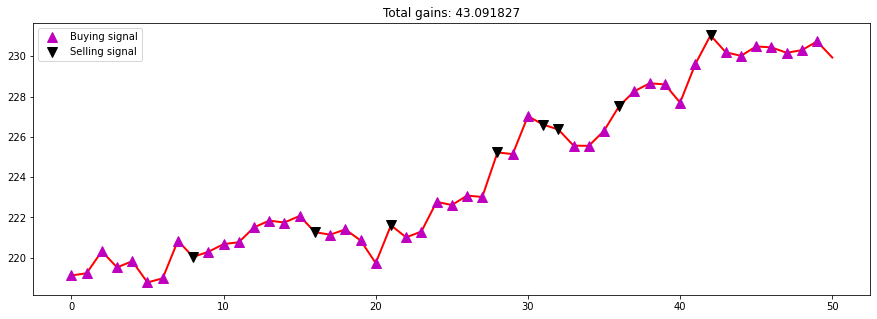

In [73]:
for t in range(l_test):
    print(state)
    start = dataset.index[count]
    action = agent.act(state)
    #print(action)
    #set_trace()
    next_state = getNDimState(test_data[['adj_close_scaled', 'volume_scaled']], t + 1, window_size + 1)
    reward = 0

    if action == 1:
        agent.inventory.append(test_data["Adj Close"].iloc[t])
        print(test_data["Adj Close"].iloc[t])
        states_buy_test.append(t)
        print("Buy: " + formatPrice(test_data["Adj Close"].iloc[t]))

    elif action == 2 and len(agent.inventory) > 0:
        bought_price = agent.inventory.pop(0)
        reward = max(test_data["Adj Close"].iloc[t] - bought_price, 0)
        #reward = test_data[t] - bought_price
        total_profit += test_data["Adj Close"].iloc[t] - bought_price
        states_sell_test.append(t)
        print("Sell: " + formatPrice(test_data["Adj Close"].iloc[t]) + " | profit: " + formatPrice(test_data["Adj Close"].iloc[t] - bought_price))

    if t == l_test - 1:
        done = True
        
    # print("State: ", state, "Action:", action, "Reward: ", reward, "Next state: ", next_state)
    agent.memory.append((state, action, reward, next_state, done))
    state = next_state
    
    

    if done:
        print("------------------------------------------")
        print("Total Profit: " + formatPrice(total_profit))
        print("------------------------------------------")

testingValues.to_csv("2017/saved_models/2layer_default/2layer_testing_data.csv", index=False)
plot_behavior(test_data['Adj Close'],states_buy_test, states_sell_test, total_profit)

Looking at the results above, our model resulted in an overall profit of $1280, and we can say that our DQN agent performs quite well on the test set. However, the performance of the model can be further improved by optimizing the hyperparameters as discussed in the model tuning section before. Also, given high complexity and low interpretability of the model, ideally there should be more tests conducted on different time periods before deploying the model for live trading.

**Conclusion**

We observed that we don’t have to decide the strategy or policy
for trading. The algorithm decides the policy by itself, and the overall approach is
much simpler and more principled than the supervised learning-based approach. 

The
policy can be parameterized by a complex model, such as a deep neural network, and
we can learn policies that are more complex and powerful than any rules a human
trader.

We used the testing set to evaluate the model and found an overall profit in the test set.

In [ ]:
X_test[['adj_close_scaled', 'volume_scaled']].hist()
X_train[['adj_close_scaled', 'volume_scaled']].hist()